# RGI15 (South Asia, East)

F. Maussion & S. Galos

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, find_duplicates, correct_geoms
import os

### specify RGI-region and storage paths

In [2]:
# Region of interest
reg = 15

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '15_rgi60_SouthAsiaEast.zip')

# Region is based on GAMDAM, use for comparison
support_dir = os.path.join(data_dir, 'l0_support_data')
gamdam_dir = os.path.join(support_dir, 'gamdam')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, _ = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
500,286,579.3,Mool,Racoviteanu,2008,"Himalaya (India, Nepal, Bhutan)",2000,2000,2000
529,3184,5294.0,Bajracharya,Racoviteanu,2008,"Himalaya (India, Nepal, Bhutan)",1967,1959,1982
566,1382,1701.4,"Frey, Paul",Paul,2011,Various (GlobGlacier),2001,2001,2001
574,133,35.5,"Bajracharya, Guo, Maharjan, Shrestha",Bajracharya,2014,"Himalaya (India, Nepal, Bhutan)",2009,2009,2009
576,4900,5344.6,"Bajracharya, Guo, Maharjan, Shrestha",Bajracharya,2014,"Himalaya (India, Nepal, Bhutan)",2005,2005,2011
577,7778,8702.2,"Bajracharya, Guo, Maharjan, Shrestha",Bajracharya,2014,"Himalaya (India, Nepal, Bhutan)",2010,2006,2011
578,16,25.0,"Bajracharya, Guo, Maharjan, Shrestha",Bajracharya,2014,"Himalaya (India, Nepal, Bhutan)",2009,2006,2011
582,2126,2775.8,"Guo, Liu",Liu,2014,China,1963,1963,1963
583,5501,6847.9,"Guo, Liu",Liu,2014,China,2005,2004,2011


In [5]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

### Apply selection criteria to create the RGI-07 data subset

In [6]:
# There are 10 ids in Sakai that are replaced by 9 Bolch outlines (one covers two)
replace_ids = [905769, 905912, 905983, 905984, 906004, 906092, 906107, 906241, 906286, 906319]

In [7]:
# try to get the data relevant for RGI07 and select by attributes
rgi7 = shp.loc[shp['subm_id'].isin([752, 765])].copy()
print(len(rgi7))
rgi7 = rgi7.loc[~rgi7['anlys_id'].isin(replace_ids)]
print(len(rgi7))
rgi7['is_rgi6'] = False

18597
18587


In [8]:
# Size filter?
needs_size_filter(rgi7)

False

### Some sanity checks 

In [9]:
dupes = find_duplicates(rgi7)

Seems Okay!


In [10]:
rgi7 = correct_geoms(rgi7)

Found 16 invalid geometries out of 18587. Correcting...
After correction, 0 geometries are still invalid.
Area changed by -90.6 m2 (-0.0000%)


In [11]:
needs_size_filter(rgi7)

False

In [12]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
752,18578,18578
765,9,9


In [13]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

### Plots 

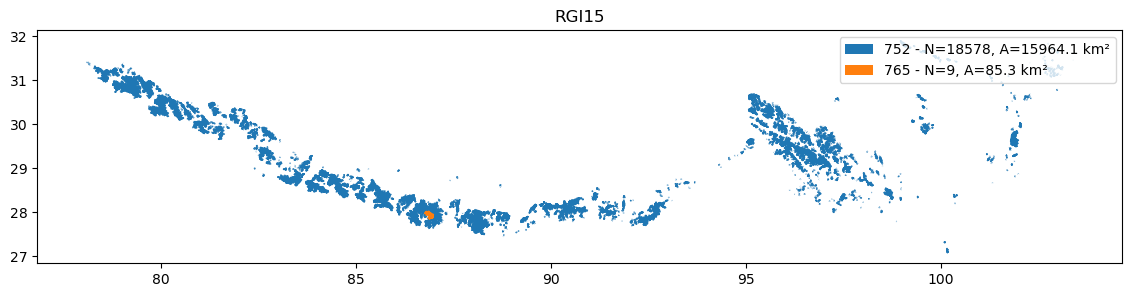

In [14]:
plot_map(rgi7, reg)

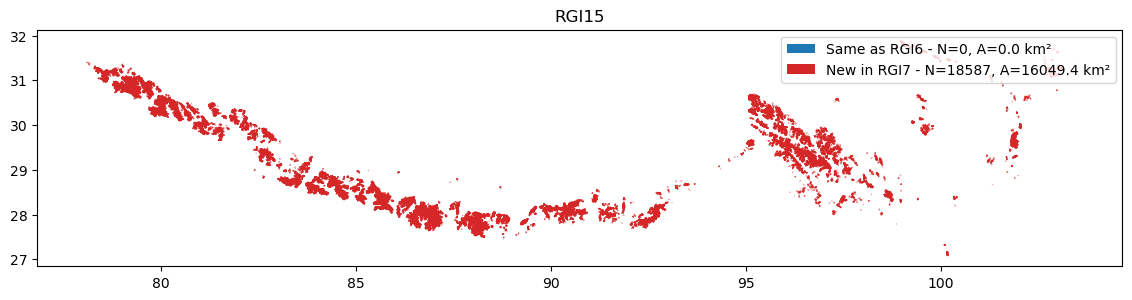

In [15]:
plot_map(rgi7, reg, is_rgi6=True)

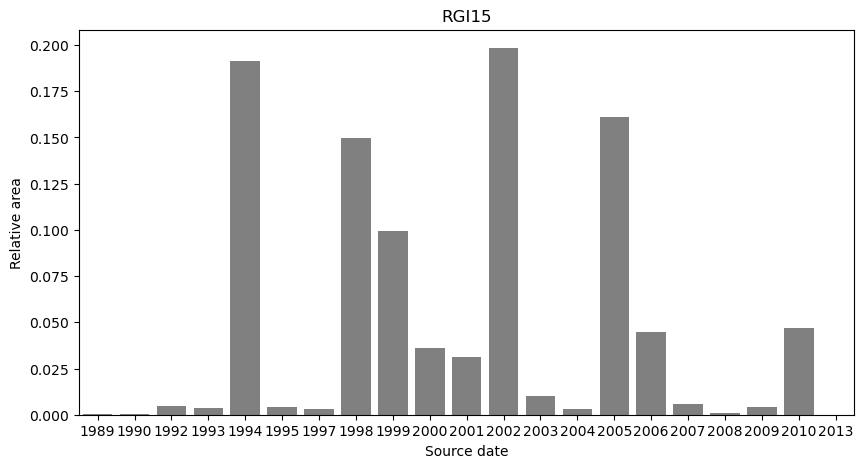

In [16]:
plot_date_hist(rgi7, reg)

### Text for github

In [17]:
fgh = sdf.T
fgh

subm_id,752,765
N,18578,9
A,15964.1,85.3
analysts,Sakai,Bolch
submitters,Sakai,Bolch
release_date,2018,2022
geog_area,Asia,Khumbu Area
src_date_mode,2005,2000
src_date_min,1989,1999
src_date_max,2013,2001


In [18]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 752     | 765         |
|:--------------|:--------|:------------|
| N             | 18578   | 9           |
| A             | 15964.1 | 85.3        |
| analysts      | Sakai   | Bolch       |
| submitters    | Sakai   | Bolch       |
| release_date  | 2018    | 2022        |
| geog_area     | Asia    | Khumbu Area |
| src_date_mode | 2005    | 2000        |
| src_date_min  | 1989    | 1999        |
| src_date_max  | 2013    | 2001        |


## Write out and tar 

In [19]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI15/
RGI15/RGI15.shx
RGI15/RGI15.prj
RGI15/RGI15.cpg
RGI15/RGI15.dbf
RGI15/RGI15.shp
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI15.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI15'], returncode=0)


## New RGI-file created - Check result!

load reference data (here GAMDAM original) to enable comparison

In [19]:
# Region file to select from gamdam
reg_file = os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions', '00_rgi70_O1Regions.shp')

In [20]:
# specify path to reference data set
import glob
from utils import open_zip_shapefile
gam_files = glob.glob(gamdam_dir + '/*.zip')
df_ref = []
for gf in gam_files:
    df_ref.append(open_zip_shapefile(gf))

df_ref = pd.concat(df_ref).reset_index()

In [21]:
# Calculate representative points for reference data
ref_rp = df_ref.representative_point()

# Make a dataframe out of it and add the original index to recover it later
ref_rp = ref_rp.to_frame('geometry')
ref_rp['orig_index'] = df_ref.index

# Read region file
reg_f = gpd.read_file(reg_file)

# Make the overlay with the RGI region of interest -> get the rep. points which are located inside the region boundaries
ref_intersect = gpd.overlay(ref_rp, reg_f.loc[reg_f.RGI_CODE == f'{reg:02d}'], how='intersection')

# Now select the entries which intersect from the original shape file (-> extract the polygons) 
df_ref = df_ref.loc[ref_intersect['orig_index'].values].copy()

### Number of elements (differences do not necessarily depict major problems)

In [22]:
# Test only Sakai
rgi7_ = shp.loc[shp['subm_id'].isin([752])].copy()

In [23]:
print('Number of glaciers in new RGI subset:', len(rgi7_))
print('Number of glaciers in reference data:', len(df_ref))
print('Difference:', len(rgi7_)-len(df_ref))

Number of glaciers in new RGI subset: 18588
Number of glaciers in reference data: 18588
Difference: 0


### Total area

In [24]:
# add an area field to the selected GAMDAM table
df_ref['area'] = df_ref.to_crs({'proj':'cea'}).area

In [25]:
# print and compare area values
Area_RGI = rgi7_['area'].sum() * 1e-6
print('Area RGI [km²]:', Area_RGI)
Area_ref = df_ref['area'].sum() * 1e-6
print('Area Ref [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:',d)

Area RGI [km²]: 16044.877350347315
Area Ref [km²]: 16044.87806719377
Area difference [km²]: -0.0007168464544520248
